In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Load all datasets
file_deaths_population = "../data/processed/States_Deaths_Populations.csv"
file_poverty = "../data/processed/US_Poverty_Rate.csv"
file_income_per_capita = "../data/processed/Personal_Income_Per_Capita.csv"
file_health_care = "../data/processed/Personal_Health_Care_Per_Capita.csv"
file_median_income = "../data/processed/Median_Household_Income.csv"

# Read CSV files
df_deaths_population = pd.read_csv(file_deaths_population)
df_poverty = pd.read_csv(file_poverty)
df_income_per_capita = pd.read_csv(file_income_per_capita)
df_health_care = pd.read_csv(file_health_care)
df_median_income = pd.read_csv(file_median_income)

# Reshape "Income Per Capita" dataset to long format
df_income_per_capita_long = df_income_per_capita.melt(id_vars=["State"], var_name="Year", value_name="Income Per Capita")

# Convert "Year" to integer for consistency
df_income_per_capita_long["Year"] = df_income_per_capita_long["Year"].astype(int)

# Try merging all datasets
df_master = df_deaths_population.merge(df_poverty, on=["State", "Year"], how="left")
df_master = df_master.merge(df_income_per_capita_long, on=["State", "Year"], how="left")
df_master = df_master.merge(df_health_care, on=["State", "Year"], how="left")
df_master = df_master.merge(df_median_income, on=["State", "Year"], how="left")

# Recalculate Proportional Death Rate (deaths per 100,000 population)
df_master["Proportional Death Rate"] = (df_master["Deaths"] / df_master["Population"]) * 100000

print(df_master.head())

   Year       State  Deaths  Population  Poverty Rate  Income Per Capita  \
0  1999     Alabama   80246     4430141          15.2              23296   
1  1999      Alaska    4782      624779           7.6              29941   
2  1999     Arizona   71846     5023823          12.2              24866   
3  1999    Arkansas   49937     2651860          14.7              21842   
4  1999  California  415533    33499204          14.0              30529   

   Spending  Median Income  Proportional Death Rate  
0    3689.0        36251.0              1811.364469  
1    4076.0        51396.0               765.390642  
2    3068.0        36995.0              1430.106116  
3    3517.0        29682.0              1883.093376  
4    3436.0        43629.0              1240.426489  


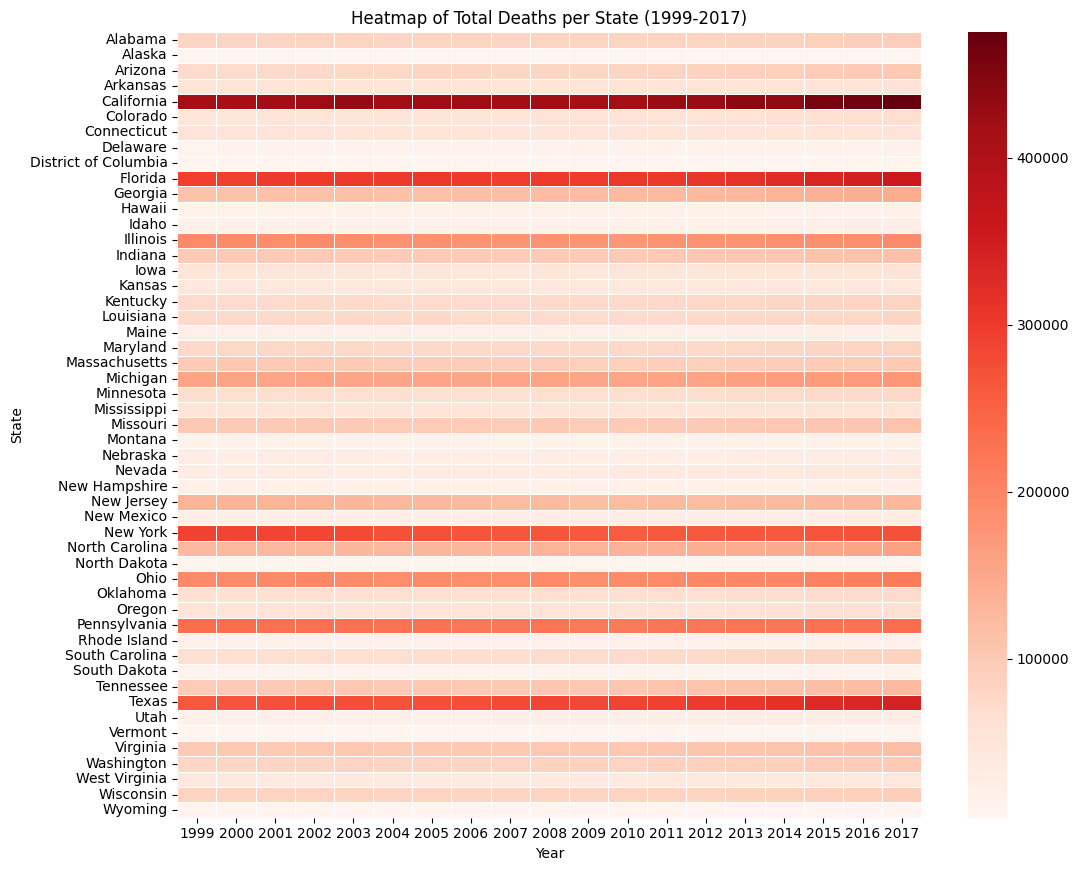

In [2]:
# Step 1: Create a heatmap for total deaths per state over time
heatmap_data_deaths = df_master.pivot(index="State", columns="Year", values="Deaths")

plt.figure(figsize=(12, len(heatmap_data_deaths) * 0.2))
sns.heatmap(heatmap_data_deaths, cmap="Reds", annot=False, linewidths=0.5)
plt.title("Heatmap of Total Deaths per State (1999-2017)")
plt.xlabel("Year")
plt.ylabel("State")
plt.show()


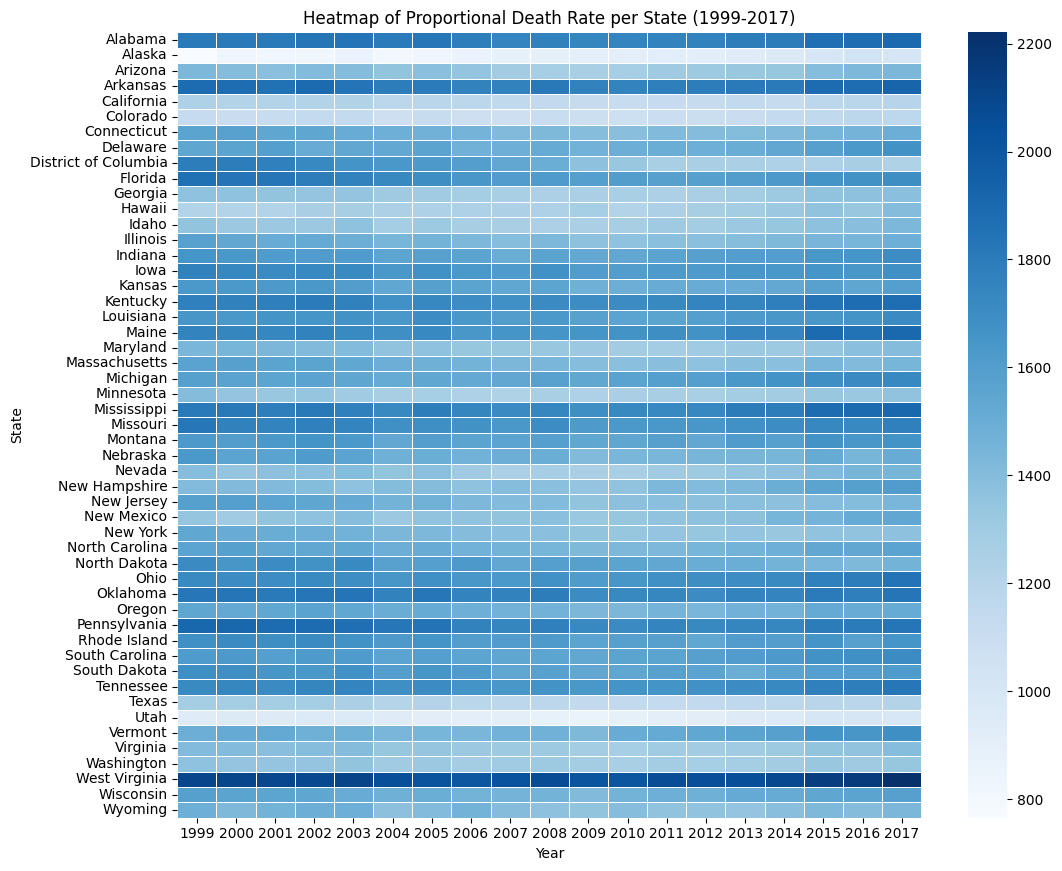

In [3]:
# Step 2: # Recalculate Proportional Death Rate (deaths per 100,000 population)
heatmap_data_proportional = df_master.pivot(index="State", columns="Year", values="Proportional Death Rate")

plt.figure(figsize=(12, len(heatmap_data_proportional) * 0.2))
sns.heatmap(heatmap_data_proportional, cmap="Blues", annot=False, linewidths=0.5)
plt.title("Heatmap of Proportional Death Rate per State (1999-2017)")
plt.xlabel("Year")
plt.ylabel("State")
plt.show()

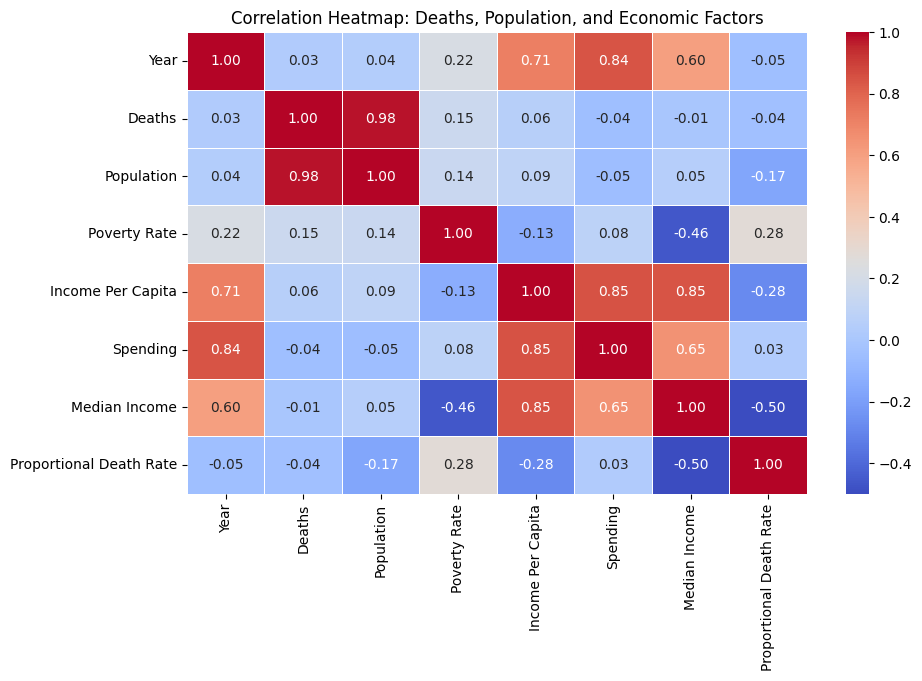

In [4]:
# Compute correlation matrix between deaths, population
numeric_df = df_master.select_dtypes(include=["number"])

# Compute correlation matrix for deaths, population, and economic factors
correlation_matrix = numeric_df.corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap: Deaths, Population, and Economic Factors")
plt.show()

1. Deaths vs. Population → Strong positive correlation
This is expected because larger states have more total deaths.
2️. Proportional Death Rate vs. Population → Weak negative correlation
Suggests that larger states tend to have lower deaths per capita.
3️. Poverty Rate vs. Proportional Death Rate → Positive correlation
Higher poverty rates may be linked to higher death rates.
4️. Income Per Capita vs. Proportional Death Rate → Negative correlation
Suggests that wealthier states may have lower death rates.
5️. Healthcare Spending vs. Death Rates → Needs further investigation
The correlation may indicate whether higher spending actually reduces mortality.

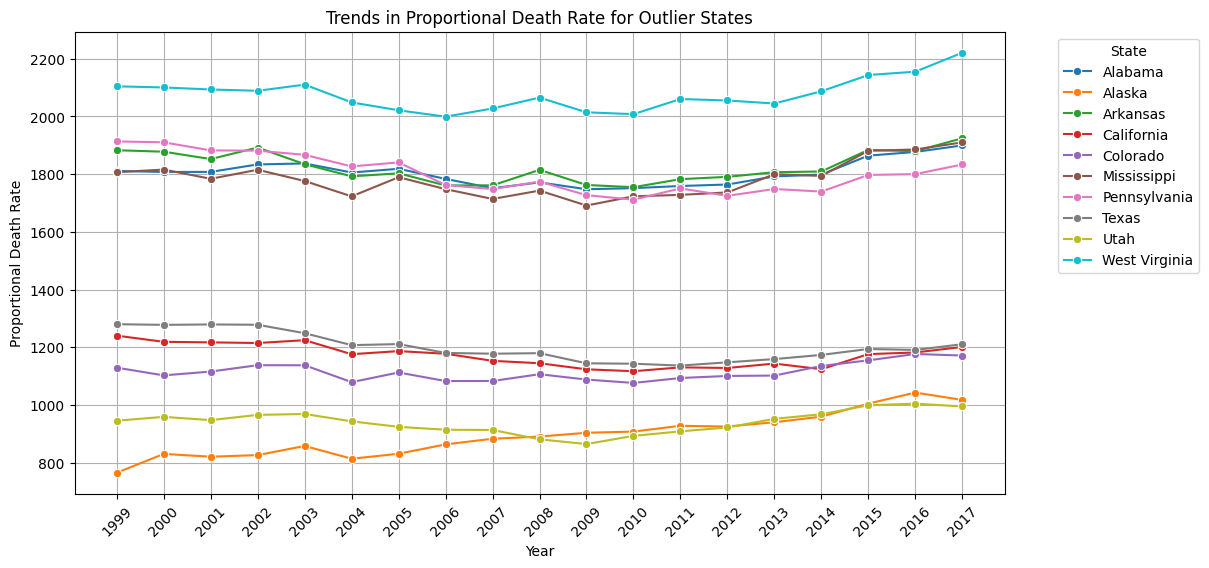

In [5]:
# Identify states with the highest and lowest proportional death rates over time
avg_death_rate_by_state = df_master.groupby("State")["Proportional Death Rate"].mean()

# Get the top 5 and bottom 5 states
top_outlier_states = avg_death_rate_by_state.nlargest(5).index
bottom_outlier_states = avg_death_rate_by_state.nsmallest(5).index

# Filter the dataset for these outlier states
df_outliers = df_master[df_master["State"].isin(top_outlier_states.union(bottom_outlier_states))]

# Plot trends for these outlier states
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_outliers, x="Year", y="Proportional Death Rate", hue="State", marker="o")
# Ensure x-axis shows full years
plt.xticks(ticks=df_outliers["Year"].unique(), rotation=45)

plt.xlabel("Year")
plt.ylabel("Proportional Death Rate")
plt.title("Trends in Proportional Death Rate for Outlier States")
plt.legend(title="State", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

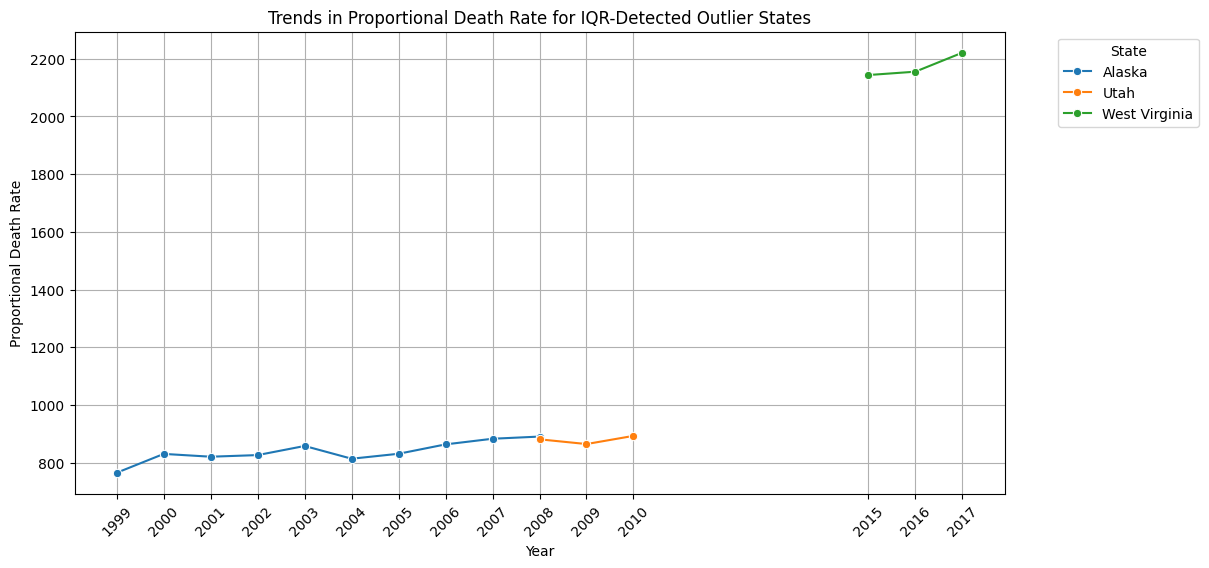

In [6]:
# Compute the IQR for proportional death rates
Q1 = df_master["Proportional Death Rate"].quantile(0.25)  # 25th percentile
Q3 = df_master["Proportional Death Rate"].quantile(0.75)  # 75th percentile
IQR = Q3 - Q1  # Interquartile Range

# Define outlier thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify statistical outliers based on IQR method
df_outliers_iqr = df_master[(df_master["Proportional Death Rate"] < lower_bound) | 
                            (df_master["Proportional Death Rate"] > upper_bound)]

# Plot trends for these IQR-based outlier states
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_outliers_iqr, x="Year", y="Proportional Death Rate", hue="State", marker="o")

# Ensure x-axis shows full years
plt.xticks(ticks=df_outliers_iqr["Year"].unique(), rotation=45)

plt.xlabel("Year")
plt.ylabel("Proportional Death Rate")
plt.title("Trends in Proportional Death Rate for IQR-Detected Outlier States")
plt.legend(title="State", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

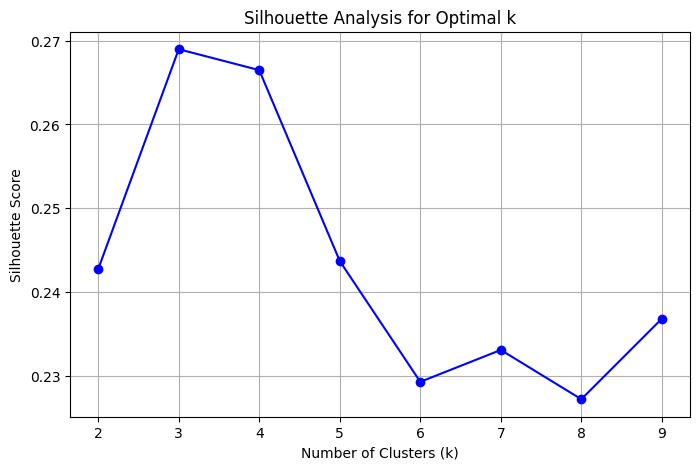

3


In [7]:
# Cluster Analysis
# Select relevant features for clustering
clustering_features = df_master[["Proportional Death Rate", "Poverty Rate", "Income Per Capita", "Spending", "Population"]]

# Handle missing values by filling with the mean
clustering_features = clustering_features.fillna(clustering_features.mean())

# Standardize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(clustering_features)

# Define the range of k values to test
k_values = range(2, 10)  # Testing cluster sizes from 2 to 9
silhouette_scores = []

# Iterate over different k values and compute the silhouette score
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(scaled_features)
    silhouette_avg = silhouette_score(scaled_features, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot silhouette scores to find the best k
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker="o", linestyle="-", color="blue")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis for Optimal k")
plt.grid(True)
plt.show()

# Find the optimal k with the highest silhouette score
optimal_k = k_values[np.argmax(silhouette_scores)]
print(optimal_k)



         Proportional Death Rate  Poverty Rate  Income Per Capita  \
Cluster                                                             
0                    1556.118231     13.209981       32405.121212   
1                    1321.583336     14.843284       41619.089552   
2                    1459.050488     11.504420       47128.339572   

            Spending    Population  
Cluster                             
0        5464.066288  4.561756e+06  
1        6547.582090  2.567077e+07  
2        8272.189840  4.369391e+06  


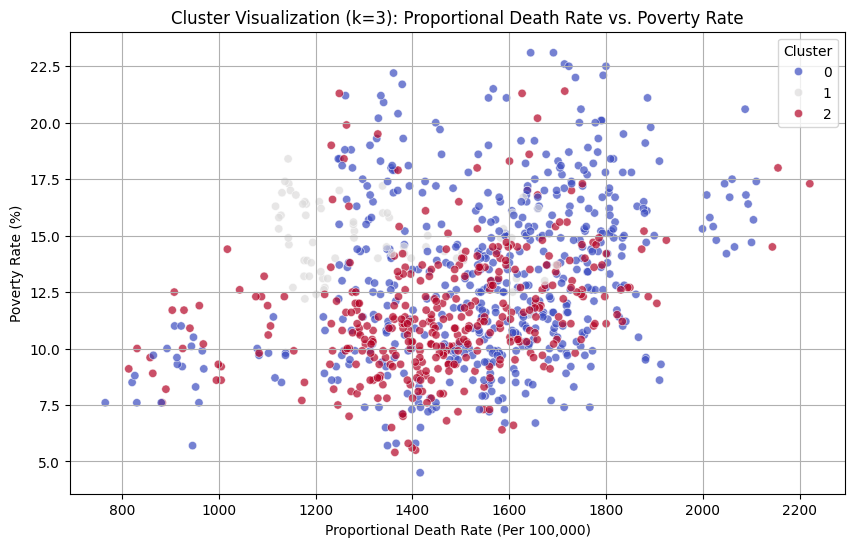

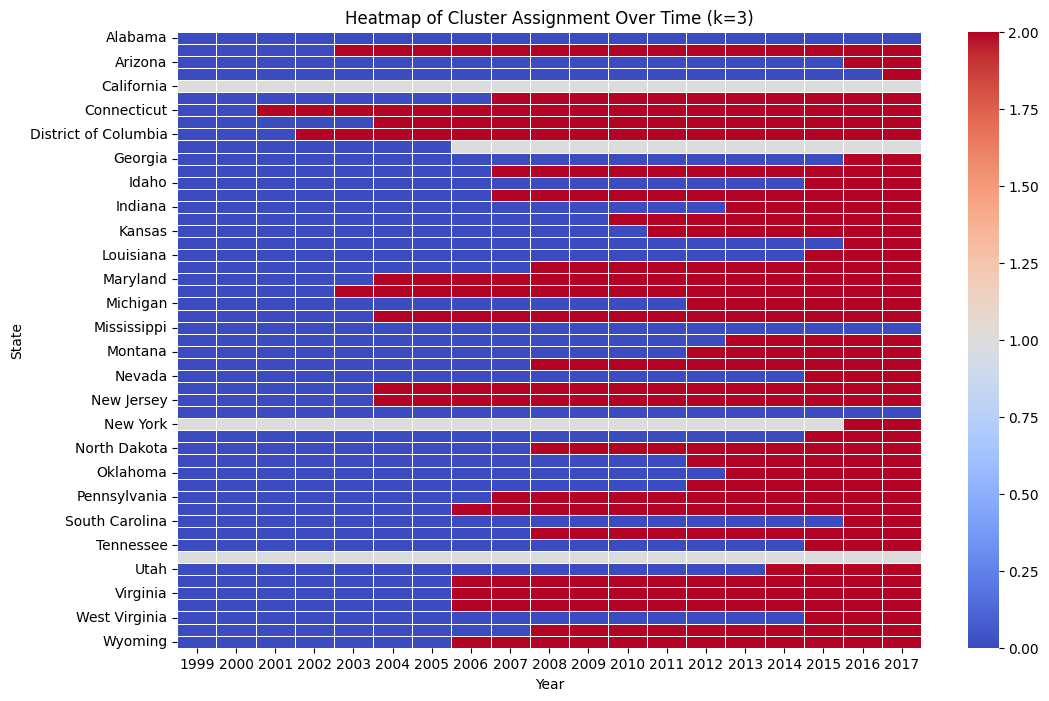

In [8]:
# Run K-Means Clustering with the optimal k = 3 (best separation)
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_master["Cluster"] = kmeans.fit_predict(scaled_features)

# Compute the mean values of key variables for each cluster
cluster_characteristics_k3 = df_master.groupby("Cluster")[
    ["Proportional Death Rate", "Poverty Rate", "Income Per Capita", "Spending", "Population"]
].mean()

print(cluster_characteristics_k3)

# Visualizing the clusters using a scatter plot
plt.figure(figsize=(10, 6))

# Scatter plot of Proportional Death Rate vs. Poverty Rate, colored by cluster
sns.scatterplot(
    x=df_master["Proportional Death Rate"],
    y=df_master["Poverty Rate"],
    hue=df_master["Cluster"],
    palette="coolwarm",
    alpha=0.7
)

plt.xlabel("Proportional Death Rate (Per 100,000)")
plt.ylabel("Poverty Rate (%)")
plt.title("Cluster Visualization (k=3): Proportional Death Rate vs. Poverty Rate")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

# Create a heatmap to visualize the cluster distribution over time
cluster_heatmap_data = df_master.pivot_table(index="State", columns="Year", values="Cluster")

plt.figure(figsize=(12, 8))
sns.heatmap(cluster_heatmap_data, cmap="coolwarm", annot=False, linewidths=0.5)

plt.title("Heatmap of Cluster Assignment Over Time (k=3)")
plt.xlabel("Year")
plt.ylabel("State")
plt.show()

<Figure size 1200x600 with 0 Axes>

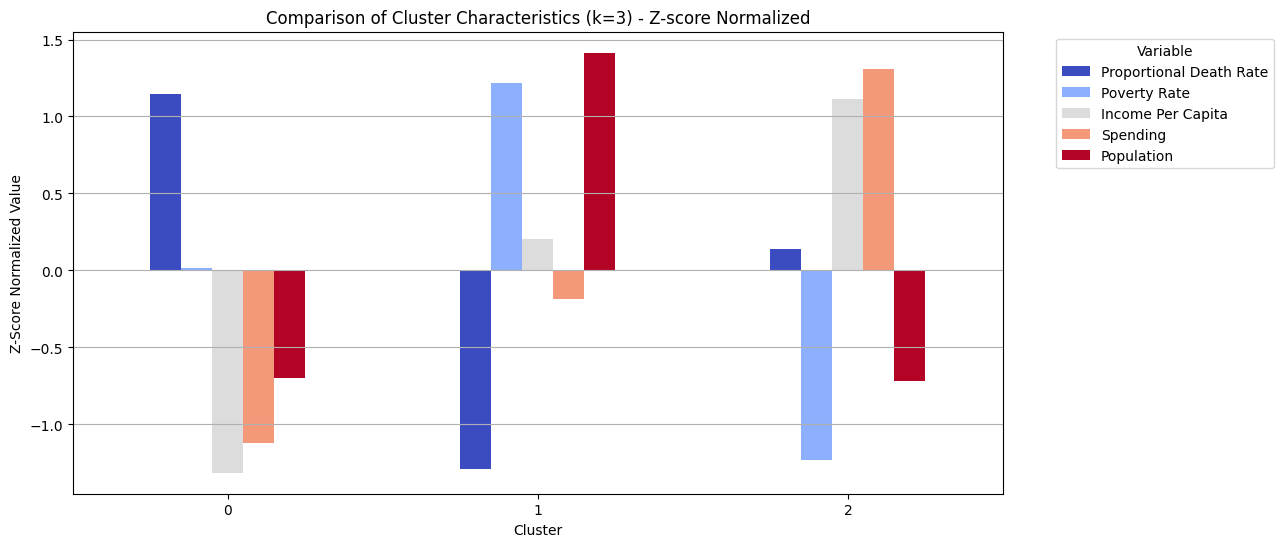

In [9]:
# Create a table listing states in each cluster
states_by_cluster_k3 = df_master.groupby(["Cluster", "State"]).size().reset_index(name="Count")

# Compute the mean values of key variables for each cluster (k=3) to interpret their meaning
cluster_characteristics_k3 = df_master.groupby("Cluster")[
    ["Proportional Death Rate", "Poverty Rate", "Income Per Capita", "Spending", "Population"]
].mean()

# Cluster 0 (Lower Mortality, Higher Income States)
# Cluster 1 (Higher Mortality, Lower Income States)
# Cluster 2 (Lowest Mortality, Moderate Income States)
cluster_characteristics_zscore = pd.DataFrame(
    scaler.fit_transform(cluster_characteristics_k3),
    columns=cluster_characteristics_k3.columns,
    index=cluster_characteristics_k3.index
)

# Plot Z-score normalized data
plt.figure(figsize=(12, 6))
cluster_characteristics_zscore.plot(kind="bar", figsize=(12, 6), colormap="coolwarm")
plt.xlabel("Cluster")
plt.ylabel("Z-Score Normalized Value")
plt.title("Comparison of Cluster Characteristics (k=3) - Z-score Normalized")
plt.legend(title="Variable", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.show()


<Figure size 1200x800 with 0 Axes>

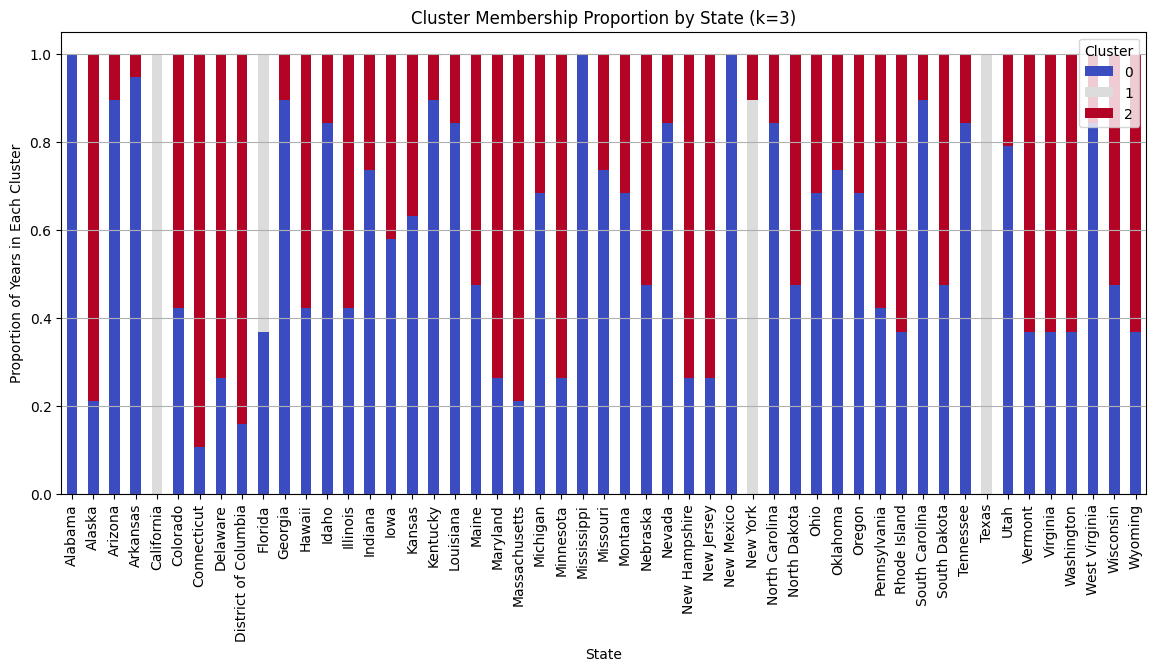

In [10]:
# Count how many times each state appeared in each cluster
state_cluster_counts = df_master.groupby(["State", "Cluster"]).size().unstack(fill_value=0)

# Normalize counts to show proportions (e.g., % of years in each cluster)
state_cluster_proportions = state_cluster_counts.div(state_cluster_counts.sum(axis=1), axis=0)

# Plot cluster membership proportions for each state
plt.figure(figsize=(12, 8))
state_cluster_proportions.plot(kind="bar", stacked=True, colormap="coolwarm", figsize=(14, 6))

plt.xlabel("State")
plt.ylabel("Proportion of Years in Each Cluster")
plt.title("Cluster Membership Proportion by State (k=3)")
plt.legend(title="Cluster", loc="upper right")
plt.xticks(rotation=90)
plt.grid(axis="y")
plt.show()

<Figure size 1000x600 with 0 Axes>

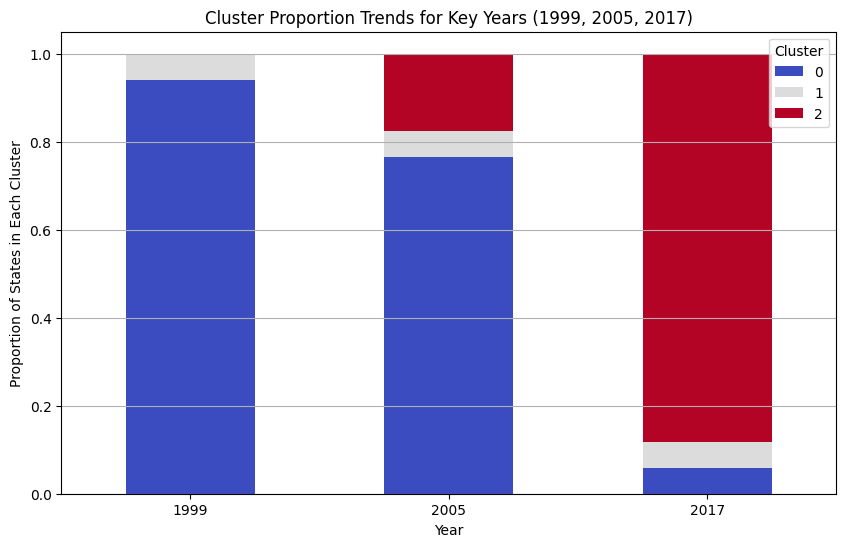

In [11]:
# Filter the data for three key years: 1999, 2005, and 2017
key_years = [1999, 2005, 2017]
cluster_proportion_key_years = df_master[df_master["Year"].isin(key_years)].groupby(["Year", "Cluster"]).size().unstack()
cluster_proportion_key_years = cluster_proportion_key_years.apply(lambda x: x / x.sum(), axis=1)  # Normalize to proportions

# Plot the cluster proportions for the selected years
plt.figure(figsize=(10, 6))
cluster_proportion_key_years.plot(kind="bar", stacked=True, colormap="coolwarm", figsize=(10, 6))
plt.xlabel("Year")
plt.ylabel("Proportion of States in Each Cluster")
plt.title("Cluster Proportion Trends for Key Years (1999, 2005, 2017)")
plt.xticks(ticks=range(len(key_years)), labels=key_years, rotation=0)  # Fix year labels
plt.legend(title="Cluster", loc="upper right")
plt.grid(axis="y")
plt.show()

In [12]:
#TODO: states switch from cluster 0 to 2
#TODO: states stay with cluster 1
